# CSCA 5642 Final: Image Colorization using GAN

I will be tackling image colorization using GAN (Generative Adversarial Network).
The dataset will be sourced from Kaggle's [Landscape color and grayscale images](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization)

### Background

Generative Adversarial Network architecture consists of two primary components: a generator and a discriminator.  The generator attempts to create data that resembles a real data to "fool" the discriminator.  Discriminator on the other hand tries to distinguish between the real data and the data generator fabricated.  Generator's tasks is to produce results that are inditinguishable from real data.

### Understanding different types of computer vision problems
There are number of common computer vision and image manipulation problems.
- Image-to-Image Translation
  - Style Transfer: Converting photos to resemble paintings of specific artists
  - Domain Translation: Converting horses to zebras, summer to winter scenes
  - Colorization: Adding realistic color to grayscale images
  - Super-Resolution: Generating high-resolution details from low-resolution images
  - Image Inpainting: Filling in missing or damaged parts of images
  - Sketch-to-Photo Conversion: Generating realistic images from simple sketches
  - Image colorization provide a unique challenge that differ from other types of image manipulations.
- Image Synthesis
  - Photorealistic Image Generation: Creating completely new but realistic-looking images
  - Conditional Image Generation: Creating images based on textual descriptions or class labels
  - Face Generation: Creating realistic human faces that don't exist
  - Texture Synthesis: Creating new textures with consistent patterns
- Image Editing and Manipulation
  - Face Aging/De-aging: Modifying images to show how someone might look older or younger
  - Image Harmonization: Integrating edited content seamlessly into images
  - Semantic Image Manipulation: Modifying images based on high-level descriptions
  - Weather/Time of Day Manipulation: Changing the weather or lighting conditions in photos

We must choose an architecture that is a good fit for Image Colorization

### Choosing the Ideal Machine Learning Model for Image Colorization

While there exists several options to train a deep learning model, after research, I have chosen pix2pix as the GAN architecture.

### Other Options:

**Standard Autoencoders**

Just using autoencoders, instead of GAN, is the simplest approach to encode the grayscale images into compressed latent representation, then decoding this representation back into colorized image.  While this is straight forward, we would lose many details during the compression stage.

**Deep Convolutional GAN (DCGAN)**

I used DCGan for week 5 monet style image creation.  While DCGan is a good candidate to perform pure generation, we don't need to create any image from scratch,  we only need to keep the existing style, only change the color.

**CycleGAN**

CycleGan built for "unpaired" image-to-image translation.  This is a good fit style transfer. (Such as applying Monet style transfer on existing images.)  There is a one key difference, since this is "unpaired" there doesn't need to be a corresponding target output image for every input image in the dataset.  (such was the case for Modet style transfer problem)

### Choosing Pix2Pix

What makes pix2pix particularly suited for image colorization is its ability to balance determinism (preserving the input structure) with creativity (applying colors). Also, we have target output image (colored image) for every input image (grayscale). Pix2Pix requires "paired" dataset, so the problem fits the Pix2Pix model the best.

# Exploratory Data Analysis

In [1]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import seaborn as sns
from collections import Counter
from PIL import Image
import pandas as pd


import tensorflow as tf
import time

In [2]:
IMAGE_PATH = './archive/landscape Images'

COLOR_PATH = IMAGE_PATH + '/color'
GRAY_PATH = IMAGE_PATH + '/gray'

In [3]:
print("Number of Color images: ",len(os.listdir(COLOR_PATH)))
print("Number of Gray images: ",len(os.listdir(GRAY_PATH)))

print("Color filenames: ",os.listdir(COLOR_PATH)[:20])
print("Gray filenames: ",os.listdir(GRAY_PATH)[:20])

NUMBER_OF_IMAGES = len(os.listdir(COLOR_PATH))

Number of Color images:  7129
Number of Gray images:  7129
Color filenames:  ['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg']
Gray filenames:  ['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg']


There are 7129 color and grayscale images.  Named from 0.jpg to 7128.jpg in each directory.

In [4]:
def create_dataframe(path):
    data = pd.DataFrame({'fileName': os.listdir(path)})
    data['filePath'] = data['fileName'].apply(lambda x: os.path.join(path, x))
    data['fileSize'] = data['filePath'].apply(lambda x: os.path.getsize(x))
    
    # to get around too many open files error
    # for (i, row) in data.iterrows():
    #     image = cv2.imread(row['filePath'])
    #     data.at[i, 'height'] = image.shape[0]
    #     data.at[i, 'width'] = image.shape[1]
    #     data.at[i, 'aspectRatio'] = round(image.shape[1] / image.shape[0], 2)
    #     data.at[i, 'channels'] = image.shape[2]
    data['img'] = data['filePath'].apply(lambda x: cv2.imread(x))
    data['height'] = data['img'].apply(lambda x: x.shape[0])
    data['width'] = data['img'].apply(lambda x: x.shape[1])
    data['aspectRatio'] = round(data['width'] / data['height'],2)
    data['channels'] = data['img'].apply(lambda x: x.shape[2])
    data['color'] = data['img'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    data['gray'] = data['img'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))
    
    
        
    return data
    
color_df = create_dataframe(COLOR_PATH)
gray_df = create_dataframe(GRAY_PATH)

In [5]:
print("Color Image Info")
print(color_df.info())
print(color_df.describe())

Color Image Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fileName     7129 non-null   object 
 1   filePath     7129 non-null   object 
 2   fileSize     7129 non-null   int64  
 3   img          7129 non-null   object 
 4   height       7129 non-null   int64  
 5   width        7129 non-null   int64  
 6   aspectRatio  7129 non-null   float64
 7   channels     7129 non-null   int64  
 8   color        7129 non-null   object 
 9   gray         7129 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 557.1+ KB
None
           fileSize       height   width  aspectRatio  channels
count   7129.000000  7129.000000  7129.0  7129.000000    7129.0
mean   15439.242951   149.886800   150.0     1.001202       3.0
std     3983.794325     2.414406     0.0     0.028314       0.0
min     4874.000000    72.000000   150.0     1.

In [6]:
print("Gray Image Info")
print(gray_df.info())
print(gray_df.describe())

Gray Image Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fileName     7129 non-null   object 
 1   filePath     7129 non-null   object 
 2   fileSize     7129 non-null   int64  
 3   img          7129 non-null   object 
 4   height       7129 non-null   int64  
 5   width        7129 non-null   int64  
 6   aspectRatio  7129 non-null   float64
 7   channels     7129 non-null   int64  
 8   color        7129 non-null   object 
 9   gray         7129 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 557.1+ KB
None
           fileSize       height   width  aspectRatio  channels
count   7129.000000  7129.000000  7129.0  7129.000000    7129.0
mean   13101.775144   149.886800   150.0     1.001202       3.0
std     3360.424840     2.414406     0.0     0.028314       0.0
min     3585.000000    72.000000   150.0     1.0

Most images are 150x150.  There seems to be an outlier.  we'll remove this to get around any unwanted outlier

In [7]:
print("non 150 height images")
print(color_df[color_df['height'] != 150].shape)
print(gray_df[gray_df['height'] != 150].shape)

non 150 height images
(23, 10)
(23, 10)


Only 23 images are not 150x150.  Let's make sure they are the same images, and remove them from the dataset

In [8]:
color_bad = color_df[color_df['height'] != 150].fileName
gray_bad = gray_df[gray_df['height'] != 150].fileName

print("Making sure the bad images are the same")
print(color_bad.equals(gray_bad))
print("Removing bad images")
color_df_cleaned = color_df[color_df['height'] == 150]
gray_df_cleaned = gray_df[gray_df['height'] == 150]

Making sure the bad images are the same
True
Removing bad images


## Sample Images

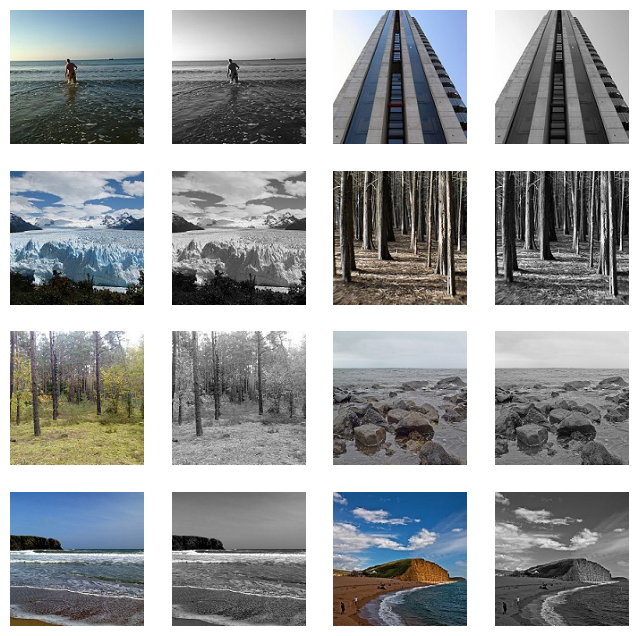

In [9]:
def display_sample_images(n=4, cols=4):
    
    sample_size = n * cols
    
    file_nums = np.random.randint(0, NUMBER_OF_IMAGES, sample_size // 2)
    
    plt.figure(figsize=(8, 8))
    for i, file_num in enumerate(file_nums):
        # Show Color Image
        img = Image.open(os.path.join(COLOR_PATH, str(file_num) + ".jpg"))
        plt.subplot(n, cols, i*2+1)
        plt.imshow(img)
        plt.axis('off')
        
        # Show Gray Image
        img2 = Image.open(os.path.join(GRAY_PATH, str(file_num) + ".jpg"))
        plt.subplot(n, cols, i*2+2)
        # color map gray.  Otherwise it will be shown in RGB
        plt.imshow(img2, cmap="gray")
        plt.axis('off')
    plt.show()
    
display_sample_images()


In [10]:
def analyze_color_distribution(images, n_samples=10):
    """
    Analyze the color distribution in the dataset
    """
    # Sample a subset of images for this analysis
    if len(images) > n_samples:
        sample_indices = np.random.choice(len(images), n_samples, replace=False)
        sample_images = [images[i] for i in sample_indices]
    else:
        sample_images = images
    
    # Analyze RGB distribution
    r_values = []
    g_values = []
    b_values = []
    
    for img in sample_images:
        # Flatten the image and collect color values
        pixels = img.reshape(-1, 3)
        r_values.extend(pixels[:, 0])
        g_values.extend(pixels[:, 1])
        b_values.extend(pixels[:, 2])
    
    # Plot histograms
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=50, color='red', alpha=0.7)
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=50, color='green', alpha=0.7)
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Value')
    
    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=50, color='blue', alpha=0.7)
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Value')
    
    plt.tight_layout()
    plt.show()
    
    # return r_values, g_values, b_values



## Color Images color distributions

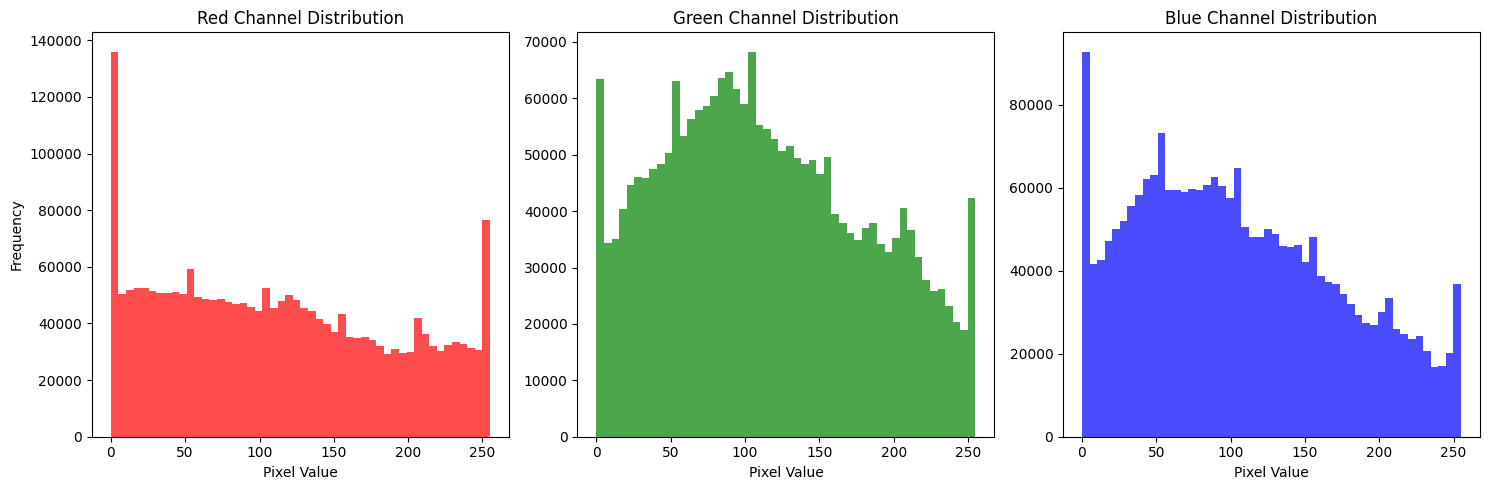

In [11]:
analyze_color_distribution(color_df_cleaned['img'].values, n_samples=100)

## Gray Images Color Distributions

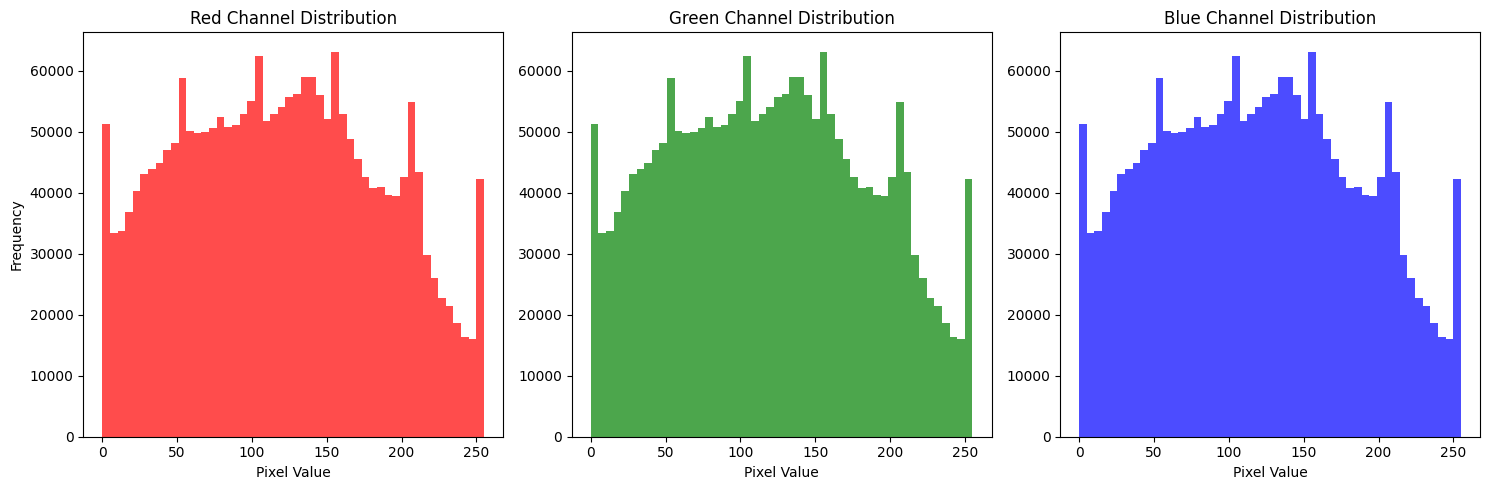

In [12]:
analyze_color_distribution(gray_df_cleaned['img'].values, n_samples=100)

In [13]:
# Function to analyze color vs grayscale pixel correlation
def analyze_color_grayscale_correlation(color_images, gray_images, n_samples=5):
    """
    Analyze how well grayscale values correlate with original color values
    """
    if len(color_images) > n_samples:
        sample_indices = np.random.choice(len(color_images), n_samples, replace=False)
    else:
        sample_indices = range(len(color_images))
    
    correlations = []
    
    for idx in sample_indices:
        color_img = color_images[idx]
        gray_img = gray_images[idx]
        
        # Convert color image to grayscale for comparison
        color_gray = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        
        # Extract first channel from grayscale image (all channels should be the same)
        if len(gray_img.shape) == 3:
            gray_channel = gray_img[:,:,0]
        else:
            gray_channel = gray_img
        
        # Calculate correlation
        correlation = np.corrcoef(color_gray.flatten(), gray_channel.flatten())[0,1]
        correlations.append(correlation)
        
        # Display example
        plt.figure(figsize=(6, 3))
        
        plt.subplot(1, 3, 1)
        plt.imshow(color_img)
        plt.title('Original Color')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(color_gray, cmap='gray')
        plt.title('Grayscale from Color')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(gray_channel, cmap='gray')
        plt.title('Dataset Grayscale')
        plt.axis('off')
        
        plt.suptitle(f'Correlation: {correlation:.4f}')
        plt.tight_layout()
        plt.show()
    
    return correlations

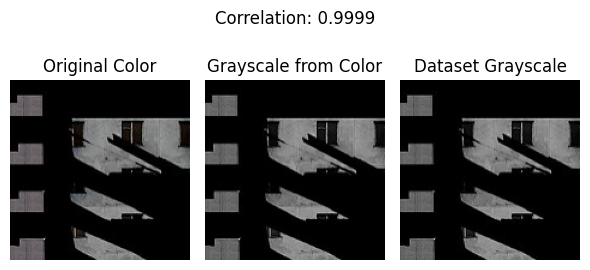

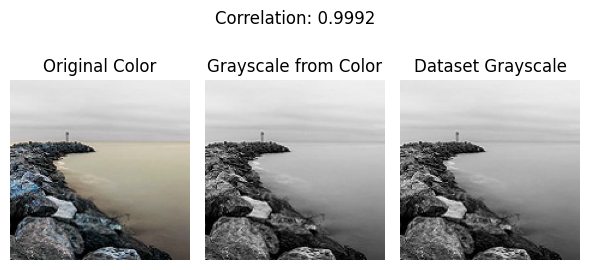

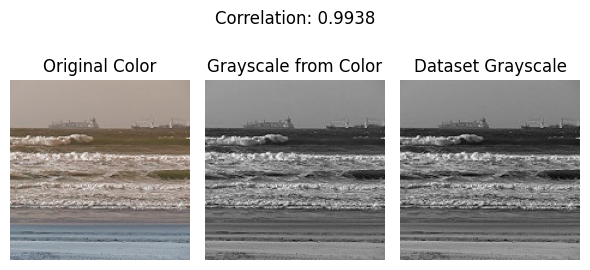

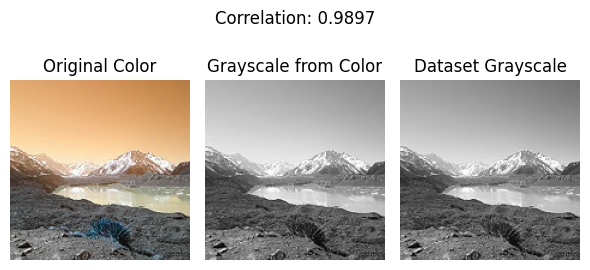

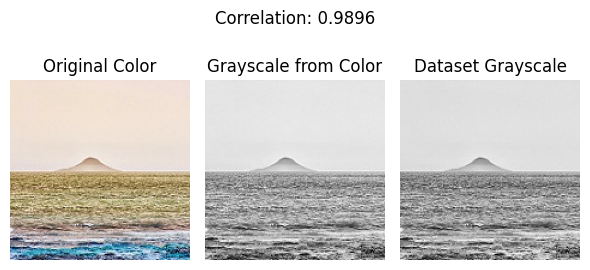

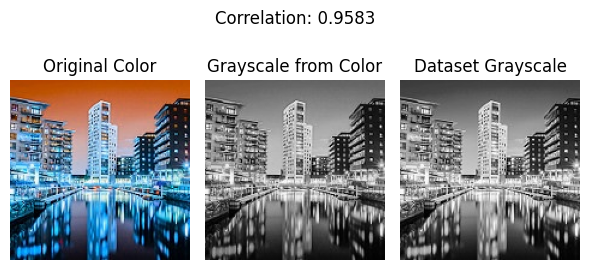

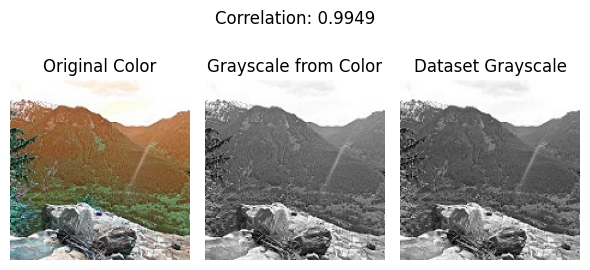

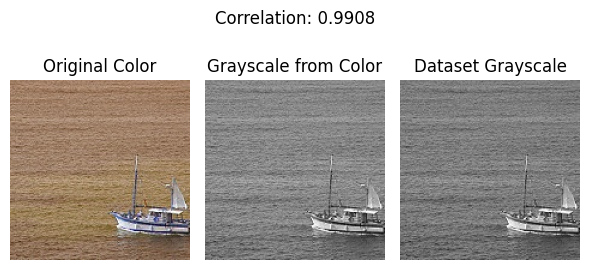

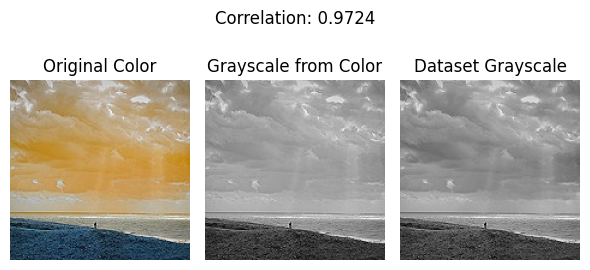

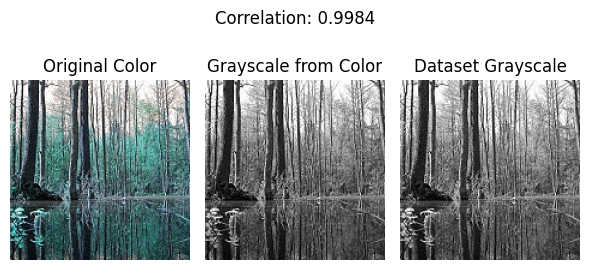

[0.9999366489944369,
 0.9991742170242038,
 0.993761329033498,
 0.989737080053783,
 0.9896456499755215,
 0.9583132734487443,
 0.9949054732920999,
 0.9907525248059131,
 0.9723571022178246,
 0.998418458649335]

In [14]:
analyze_color_grayscale_correlation(color_df_cleaned['img'].values, gray_df_cleaned['img'].values, n_samples=10)

As expected, the color images turned to grayscale is pretty much the same as the gray images.

In [15]:
IMAGE_SIZE = 128

In [16]:
def prepare_data_from_dataframe(color_df, gray_df):
    """
    Prepare data from pandas DataFrames containing image data
    
    Args:
        color_df: DataFrame with color images
        gray_df: DataFrame with grayscale images
        max_images: Maximum number of images to use (for testing)
    
    Returns:
        Arrays of color and grayscale images
    """
    # Make sure the DataFrames are matched by filename
    color_df = color_df.set_index('fileName')
    gray_df = gray_df.set_index('fileName')
    common_files = set(color_df.index).intersection(set(gray_df.index))
    
    print(f"Found {len(common_files)} matching image pairs")
    
    # Create empty lists to store preprocessed images
    color_img = []
    gray_img = []
    
    # Process each image pair
    print("Processing images...")
    for filename in common_files:
        # Get color image and normalize
        color_image = color_df.loc[filename, 'color']
        # color_image = color_image.astype('float32') / 255.0
        
        # Get grayscale image and normalize
        gray_image = gray_df.loc[filename, 'color']  # Using 'color' column which has RGB format
        # gray_image = gray_image.astype('float32') / 255.0
        
        color_image = cv2.resize(color_image, (IMAGE_SIZE, IMAGE_SIZE))
        gray_image = cv2.resize(gray_image, (IMAGE_SIZE, IMAGE_SIZE))
        
        color_image = (color_image.astype(np.float32) / 127.5) - 1.0
        gray_image = (gray_image.astype(np.float32) / 127.5) - 1.0
        
        color_img.append(color_image)
        gray_img.append(gray_image)
    
    return np.array(color_img), np.array(gray_img)

color_images, gray_images = prepare_data_from_dataframe(color_df_cleaned, gray_df_cleaned)

Found 7106 matching image pairs
Processing images...


In [17]:
BATCH_SIZE = 4
LAMBDA = 100
EPOCHS = 30

In [18]:
def preprocess_data(color_images, gray_images, train_split=0.8):
    """Split data into training and validation sets"""
    # Determine split index
    num_samples = len(color_images)
    split_idx = int(num_samples * train_split)
    
    # Create training datasets
    train_color = color_images[:split_idx]
    train_gray = gray_images[:split_idx]
    
    # Create validation datasets
    val_color = color_images[split_idx:]
    val_gray = gray_images[split_idx:]
    
    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_gray, train_color))
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((val_gray, val_color))
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset

train_dataset, val_dataset = preprocess_data(color_images, gray_images)

In [19]:
# Model building functions
def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [ ]:
def build_generator():
    """Build the U-Net generator model - true to pix2pix but with memory efficiency"""
    inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    
    # Encoder (downsampling)
    # Using fewer filters at each layer compared to original pix2pix
    down_stack = [
        downsample(16, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 16)
        downsample(32, 4),                         # (batch_size, 32, 32, 32)
        downsample(64, 4),                         # (batch_size, 16, 16, 64)
        downsample(128, 4),                        # (batch_size, 8, 8, 128)
        downsample(256, 4),                        # (batch_size, 4, 4, 256)
        downsample(256, 4),                        # (batch_size, 2, 2, 256)
    ]
    
    # Encoder pass
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Decoder (upsampling)
    # Using fewer filters at each layer compared to original pix2pix
    up_stack = [
        upsample(256, 4, apply_dropout=True),      # (batch_size, 4, 4, 256)
        upsample(128, 4, apply_dropout=True),      # (batch_size, 8, 8, 128)
        upsample(64, 4),                           # (batch_size, 16, 16, 64)
        upsample(32, 4),                           # (batch_size, 32, 32, 32)
        upsample(16, 4),                           # (batch_size, 64, 64, 16)
    ]
    
    # Decoder pass with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # Handle dimension issues with resize if needed
        if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
            x = tf.image.resize(x, [skip.shape[1], skip.shape[2]])
        x = tf.keras.layers.Concatenate()([x, skip])
    
    # Final output layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same',
        kernel_initializer=initializer, activation='tanh')  # (batch_size, 128, 128, 3)
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
def build_discriminator():
    """Build the PatchGAN discriminator - true to pix2pix but with memory efficiency"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Input layers
    inp = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='target_image')
    
    # Concatenate inputs
    x = tf.keras.layers.Concatenate()([inp, tar])  # (batch_size, 128, 128, 6)
    
    # PatchGAN layers - using fewer filters than original
    down1 = downsample(16, 4, False)(x)            # (batch_size, 64, 64, 16)
    down2 = downsample(32, 4)(down1)               # (batch_size, 32, 32, 32)
    down3 = downsample(64, 4)(down2)               # (batch_size, 16, 16, 64)
    
    # Zero padding and final convolution
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(
        256, 4, strides=1, padding='valid',
        kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    batchnorm = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    # Final 1x1 output (without sigmoid - will use from_logits=True in loss)
    last = tf.keras.layers.Conv2D(
        1, 4, strides=1, padding='valid',
        kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
    """Calculate generator loss"""
    # GAN loss for fooling the discriminator
    gan_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 loss for color accuracy
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # Combined loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    """Calculate discriminator loss"""
    # Real image loss
    real_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    
    # Generated image loss
    generated_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    # Total loss
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [23]:
@tf.function
def train_step(input_images, target_images, generator, discriminator, 
               generator_optimizer, discriminator_optimizer):
    """Single training step"""
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate colorized output
        gen_output = generator(input_images, training=True)
        
        # Discriminator predictions
        disc_real_output = discriminator([input_images, target_images], training=True)
        disc_generated_output = discriminator([input_images, gen_output], training=True)
        
        # Calculate losses
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target_images)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [ ]:
def generate_and_save_images(model, test_input, target, filename=None):
    """Generate colorized images and save if filename is provided"""
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(15, 3))
    
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input (Grayscale)', 'Ground Truth (Color)', 'Predicted (Color)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        
        # Get the pixel values between [0, 1]
        img = tf.clip_by_value(display_list[i], 0, 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

def display_sample_results(model, dataset, num_samples=3):
    """Display sample results during training"""
    for input_image, target_image in dataset.take(1):
        for i in range(min(num_samples, input_image.shape[0])):
            generate_and_save_images(
                model,
                input_image[i:i+1],
                target_image[i:i+1])

In [ ]:
def train_model(train_dataset, val_dataset, epochs):
    """Train the pix2pix model"""
    print("Starting training...")
    # Build models
    generator = build_generator()
    # Print summary of the generator model
    print(generator.summary())
    discriminator = build_discriminator()
    print(discriminator.summary())
    
    # Define optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    
    # Create checkpoints
    checkpoint_dir = './checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer,
        generator=generator,
        discriminator=discriminator)
    
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Training loop
    for epoch in range(epochs):
        start_time = time.time()
        
        # Initialize metrics
        gen_total_loss_avg = tf.keras.metrics.Mean()
        gen_gan_loss_avg = tf.keras.metrics.Mean()
        gen_l1_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()
        
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training
        for input_image, target_image in train_dataset:
            # Train on batch
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(
                input_image, target_image, generator, discriminator,
                generator_optimizer, discriminator_optimizer)
            
            # Update metrics
            gen_total_loss_avg.update_state(gen_total_loss)
            gen_gan_loss_avg.update_state(gen_gan_loss)
            gen_l1_loss_avg.update_state(gen_l1_loss)
            disc_loss_avg.update_state(disc_loss)
        
        # Validation
        val_gen_total_loss_avg = tf.keras.metrics.Mean()
        val_gen_gan_loss_avg = tf.keras.metrics.Mean()
        val_gen_l1_loss_avg = tf.keras.metrics.Mean()
        val_disc_loss_avg = tf.keras.metrics.Mean()
        
        for input_image, target_image in val_dataset:
            # Generate output
            gen_output = generator(input_image, training=False)
            
            # Discriminator predictions
            disc_real_output = discriminator([input_image, target_image], training=False)
            disc_generated_output = discriminator([input_image, gen_output], training=False)
            
            # Calculate losses
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, target_image)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
            
            # Update metrics
            val_gen_total_loss_avg.update_state(gen_total_loss)
            val_gen_gan_loss_avg.update_state(gen_gan_loss)
            val_gen_l1_loss_avg.update_state(gen_l1_loss)
            val_disc_loss_avg.update_state(disc_loss)
        
        # Print epoch results
        time_taken = time.time() - start_time
        print(f"Time taken: {time_taken:.2f}s")
        
        print(f"Training: Gen Loss: {gen_total_loss_avg.result():.4f}, "
              f"Gen GAN Loss: {gen_gan_loss_avg.result():.4f}, "
              f"Gen L1 Loss: {gen_l1_loss_avg.result():.4f}, "
              f"Disc Loss: {disc_loss_avg.result():.4f}")
        
        print(f"Validation: Gen Loss: {val_gen_total_loss_avg.result():.4f}, "
              f"Gen GAN Loss: {val_gen_gan_loss_avg.result():.4f}, "
              f"Gen L1 Loss: {val_gen_l1_loss_avg.result():.4f}, "
              f"Disc Loss: {val_disc_loss_avg.result():.4f}")
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        # Generate and display sample images
        if (epoch + 1) % 5 == 0:
            display_sample_results(generator, val_dataset, num_samples=6)
    
    # Final save
    checkpoint.save(file_prefix=checkpoint_prefix)
    
    return generator, discriminator

Starting training...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 16)   768         ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 32)   8320        ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 64)   33024       ['sequen

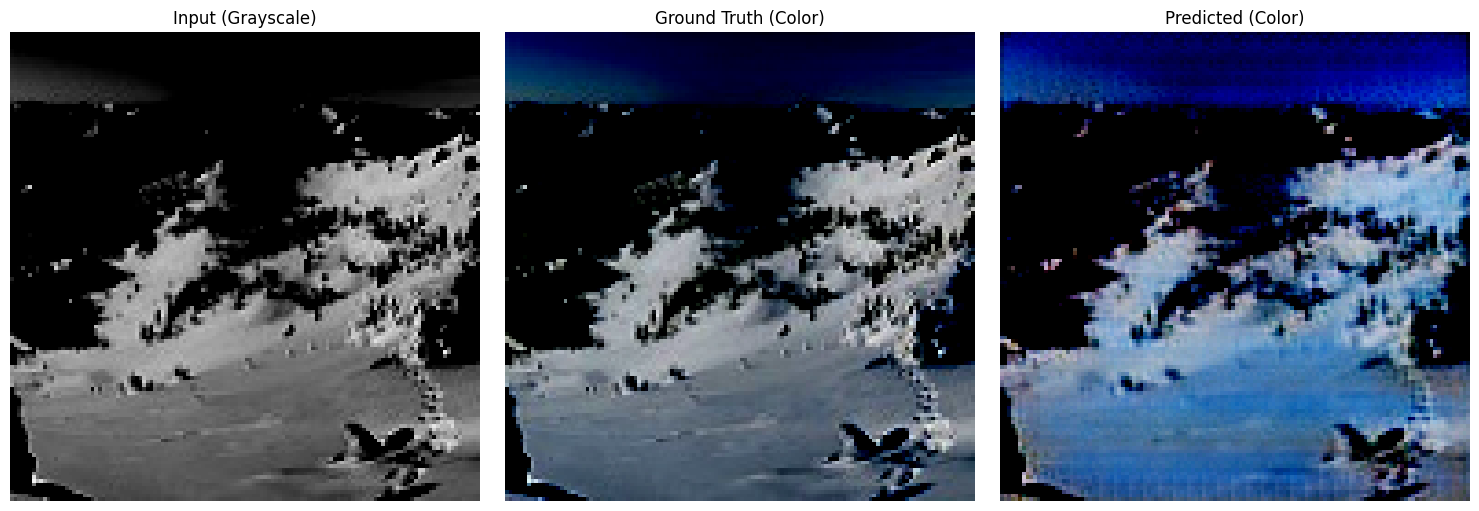

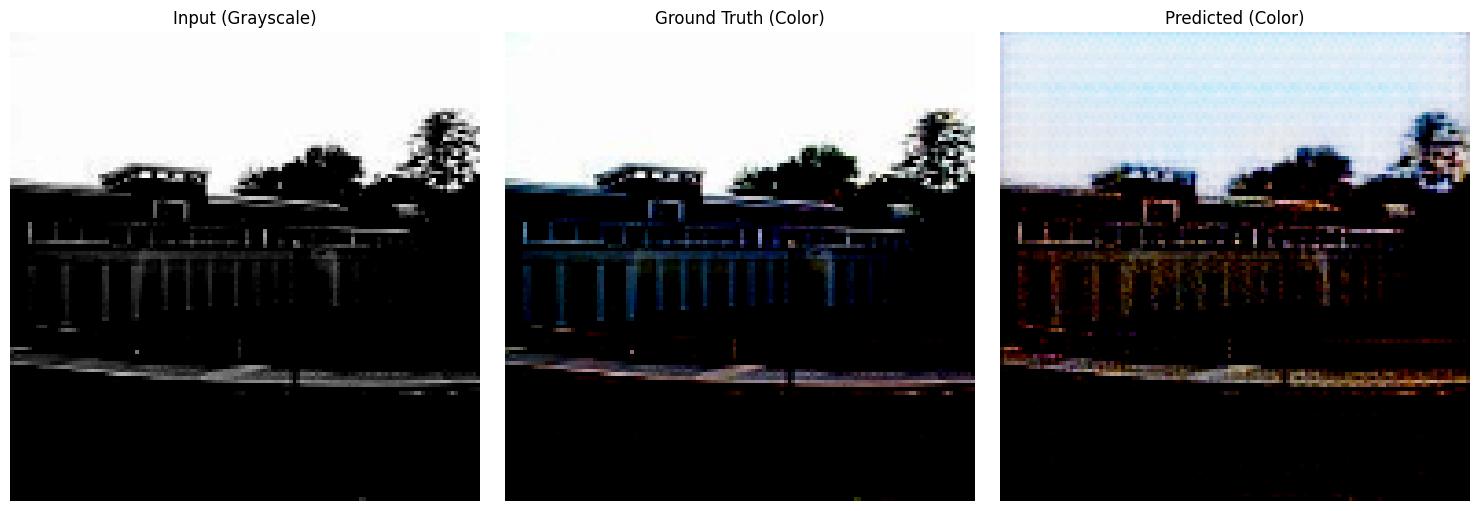

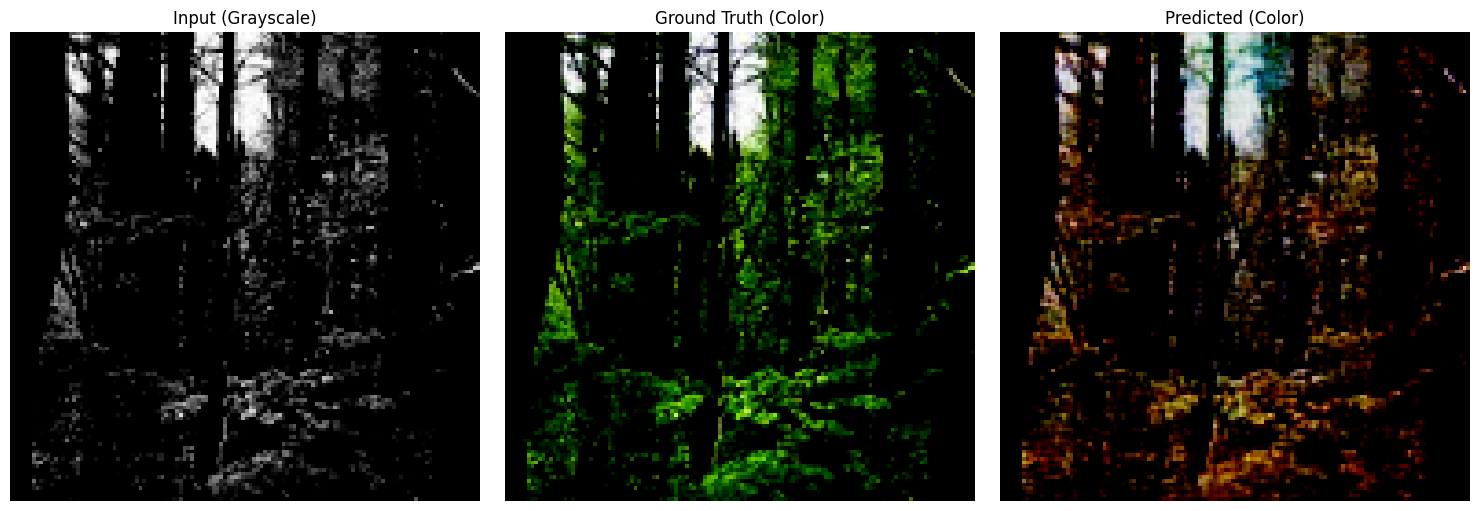

Epoch 6/50
Time taken: 34.58s
Training: Gen Loss: 15.6257, Gen GAN Loss: 3.8242, Gen L1 Loss: 0.1180, Disc Loss: 0.3044
Validation: Gen Loss: 14.5230, Gen GAN Loss: 1.8549, Gen L1 Loss: 0.1267, Disc Loss: 1.4874
Epoch 7/50
Time taken: 34.96s
Training: Gen Loss: 15.2186, Gen GAN Loss: 4.0242, Gen L1 Loss: 0.1119, Disc Loss: 0.4340
Validation: Gen Loss: 14.0805, Gen GAN Loss: 1.8800, Gen L1 Loss: 0.1220, Disc Loss: 1.5273
Epoch 8/50
Time taken: 36.53s
Training: Gen Loss: 15.2780, Gen GAN Loss: 4.5439, Gen L1 Loss: 0.1073, Disc Loss: 0.2661
Validation: Gen Loss: 14.1885, Gen GAN Loss: 2.1110, Gen L1 Loss: 0.1208, Disc Loss: 1.8656
Epoch 9/50
Time taken: 36.38s
Training: Gen Loss: 13.6409, Gen GAN Loss: 3.1502, Gen L1 Loss: 0.1049, Disc Loss: 0.7923
Validation: Gen Loss: 12.4350, Gen GAN Loss: 0.7189, Gen L1 Loss: 0.1172, Disc Loss: 1.3973
Epoch 10/50
Time taken: 37.25s
Training: Gen Loss: 13.0664, Gen GAN Loss: 2.8205, Gen L1 Loss: 0.1025, Disc Loss: 0.5992
Validation: Gen Loss: 14.1454, 

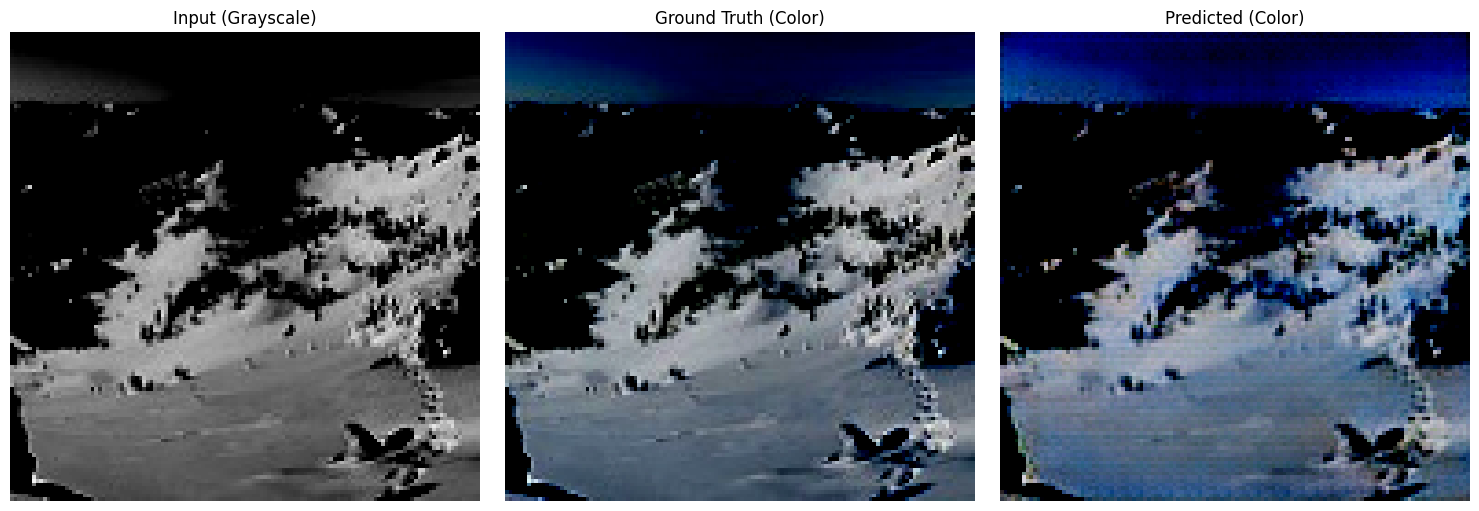

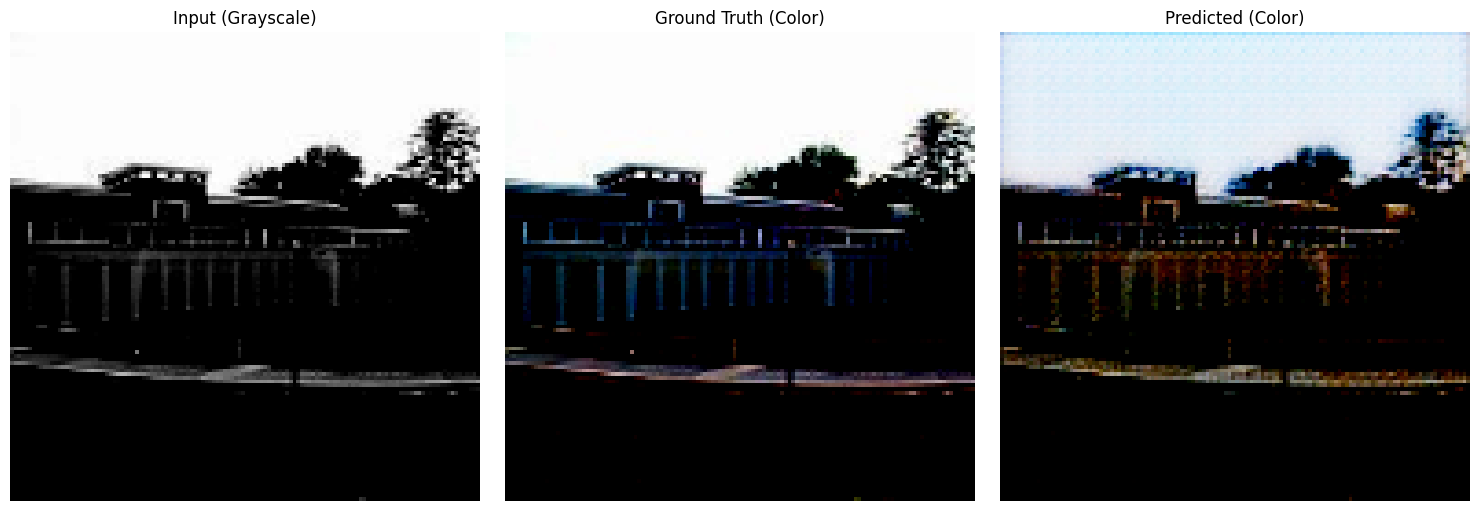

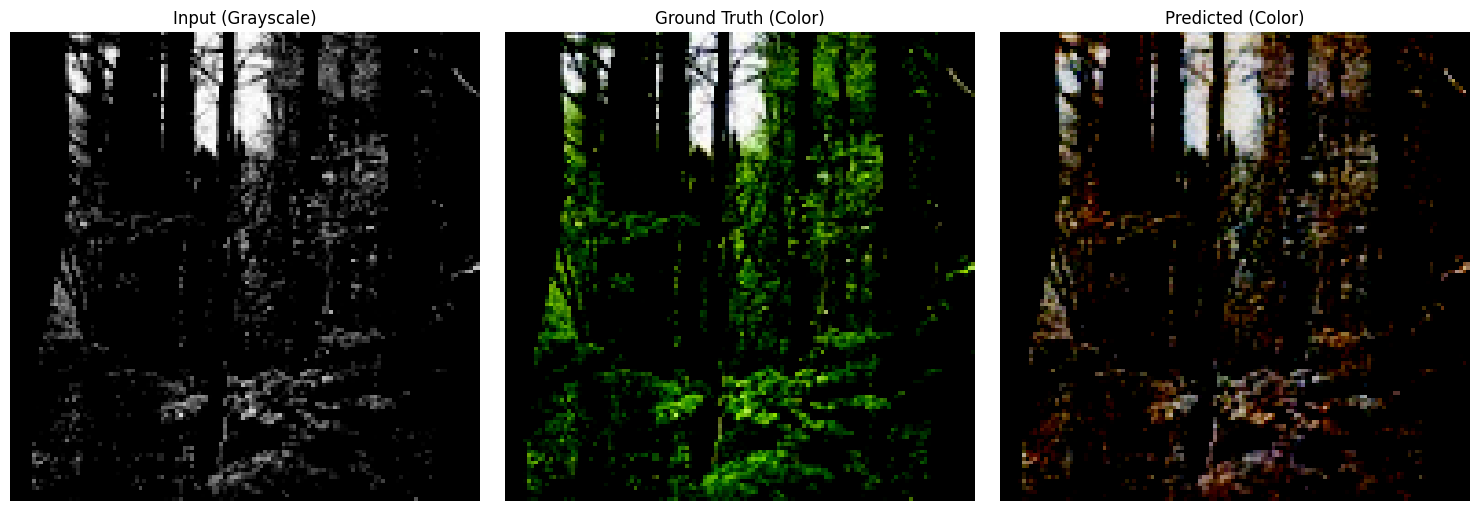

Epoch 11/50
Time taken: 38.17s
Training: Gen Loss: 15.2596, Gen GAN Loss: 5.0122, Gen L1 Loss: 0.1025, Disc Loss: 0.2088
Validation: Gen Loss: 14.0212, Gen GAN Loss: 1.8425, Gen L1 Loss: 0.1218, Disc Loss: 1.7121
Epoch 12/50
Time taken: 40.33s
Training: Gen Loss: 15.3991, Gen GAN Loss: 5.5448, Gen L1 Loss: 0.0985, Disc Loss: 0.1887
Validation: Gen Loss: 13.9001, Gen GAN Loss: 2.2822, Gen L1 Loss: 0.1162, Disc Loss: 1.9658
Epoch 13/50
Time taken: 49.30s
Training: Gen Loss: 16.0222, Gen GAN Loss: 6.4019, Gen L1 Loss: 0.0962, Disc Loss: 0.1008
Validation: Gen Loss: 13.5968, Gen GAN Loss: 1.9509, Gen L1 Loss: 0.1165, Disc Loss: 2.1437
Epoch 14/50
Time taken: 44.50s
Training: Gen Loss: 14.2547, Gen GAN Loss: 4.9764, Gen L1 Loss: 0.0928, Disc Loss: 0.3992
Validation: Gen Loss: 14.2432, Gen GAN Loss: 2.2735, Gen L1 Loss: 0.1197, Disc Loss: 1.9031
Epoch 15/50
Time taken: 44.50s
Training: Gen Loss: 14.5624, Gen GAN Loss: 5.3519, Gen L1 Loss: 0.0921, Disc Loss: 0.2421
Validation: Gen Loss: 14.15

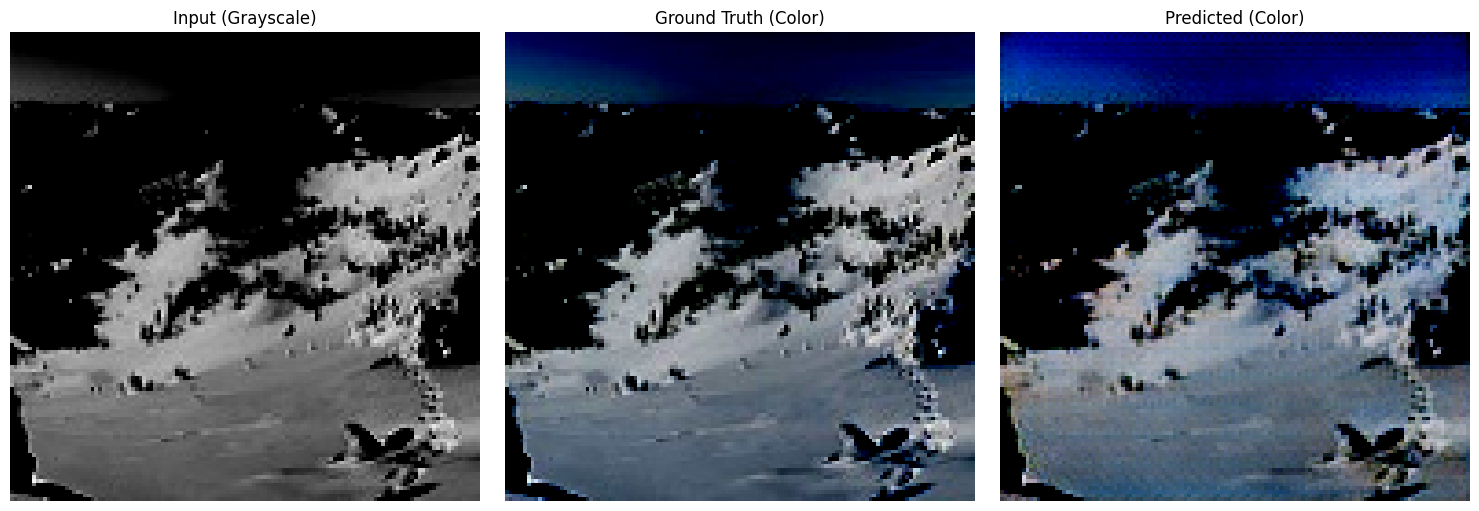

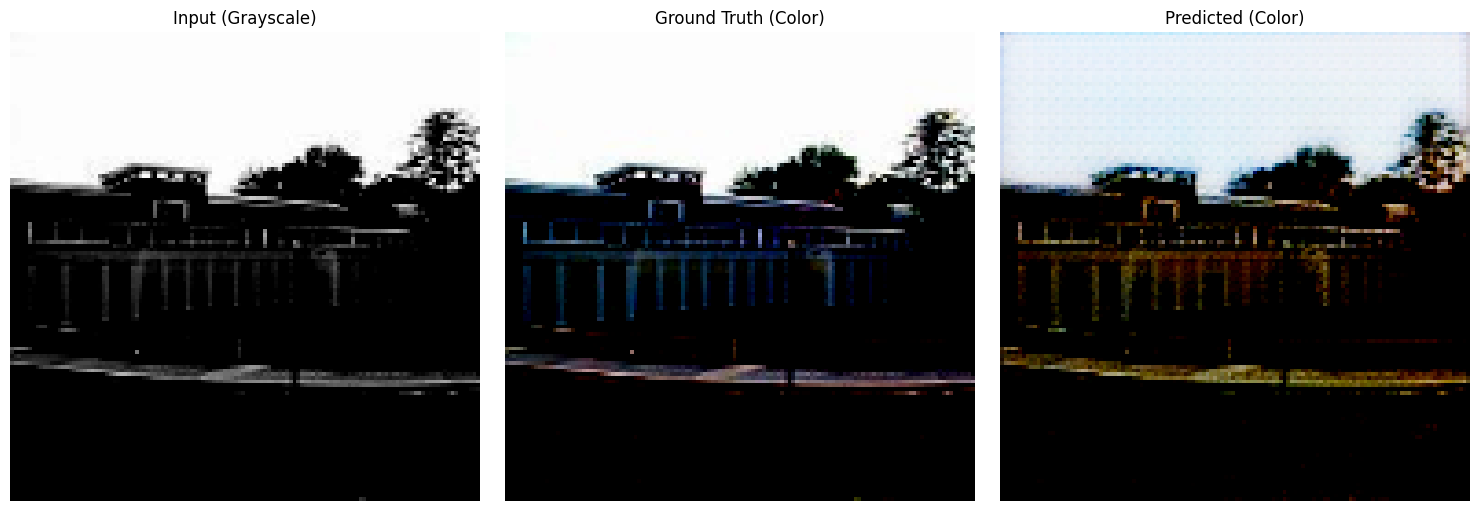

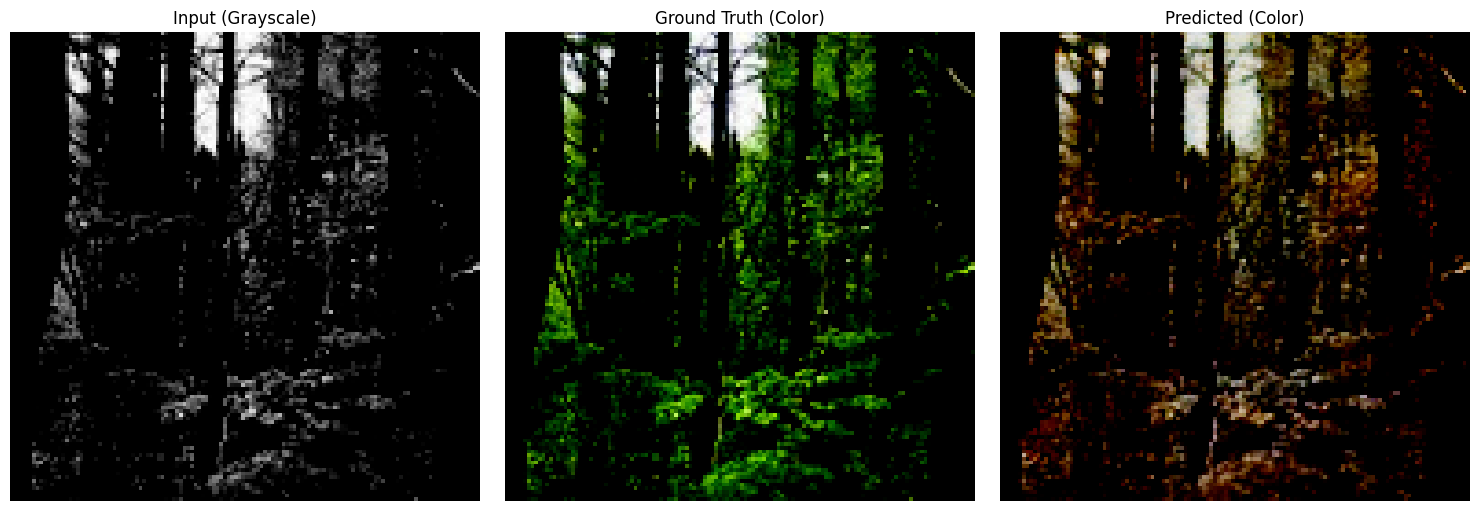

Epoch 16/50
Time taken: 38.65s
Training: Gen Loss: 14.5689, Gen GAN Loss: 5.5454, Gen L1 Loss: 0.0902, Disc Loss: 0.2268
Validation: Gen Loss: 11.8742, Gen GAN Loss: 0.7359, Gen L1 Loss: 0.1114, Disc Loss: 1.4318
Epoch 17/50
Time taken: 34.11s
Training: Gen Loss: 12.0002, Gen GAN Loss: 3.2856, Gen L1 Loss: 0.0871, Disc Loss: 0.6399
Validation: Gen Loss: 13.3085, Gen GAN Loss: 1.7654, Gen L1 Loss: 0.1154, Disc Loss: 1.9587
Epoch 18/50
Time taken: 37.12s
Training: Gen Loss: 15.4296, Gen GAN Loss: 6.5403, Gen L1 Loss: 0.0889, Disc Loss: 0.0778
Validation: Gen Loss: 14.2972, Gen GAN Loss: 2.5839, Gen L1 Loss: 0.1171, Disc Loss: 2.2597
Epoch 19/50
Time taken: 36.01s
Training: Gen Loss: 15.0630, Gen GAN Loss: 5.9609, Gen L1 Loss: 0.0910, Disc Loss: 0.3026
Validation: Gen Loss: 11.7306, Gen GAN Loss: 0.6862, Gen L1 Loss: 0.1104, Disc Loss: 1.3908
Epoch 20/50
Time taken: 37.82s
Training: Gen Loss: 11.2455, Gen GAN Loss: 2.9082, Gen L1 Loss: 0.0834, Disc Loss: 0.7452
Validation: Gen Loss: 14.81

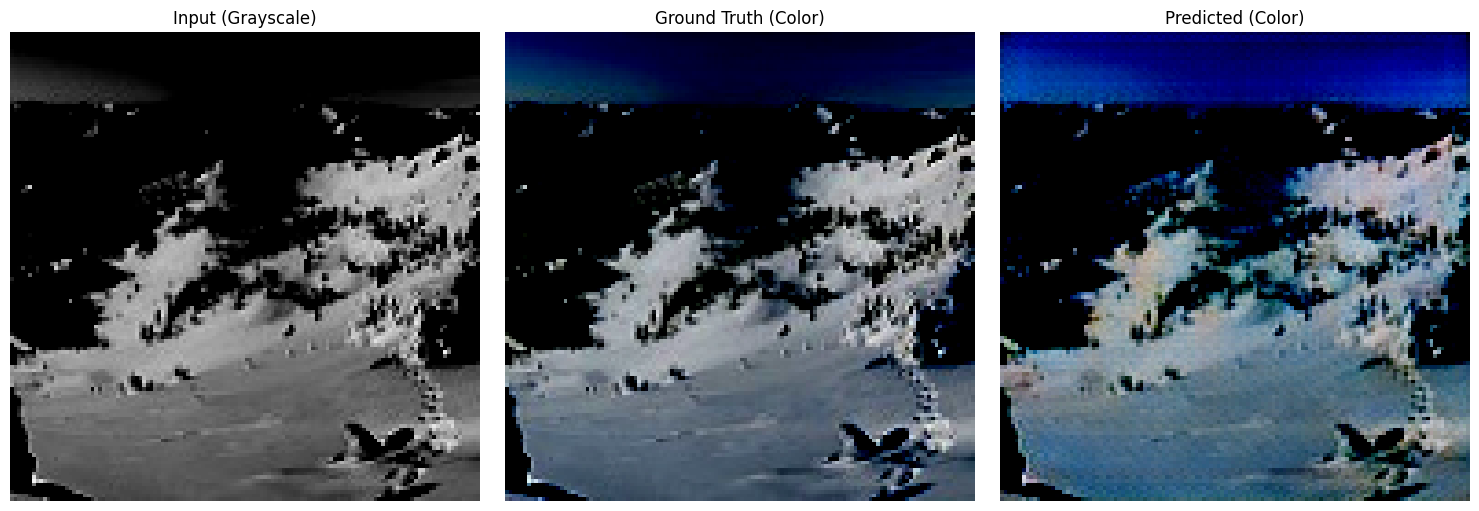

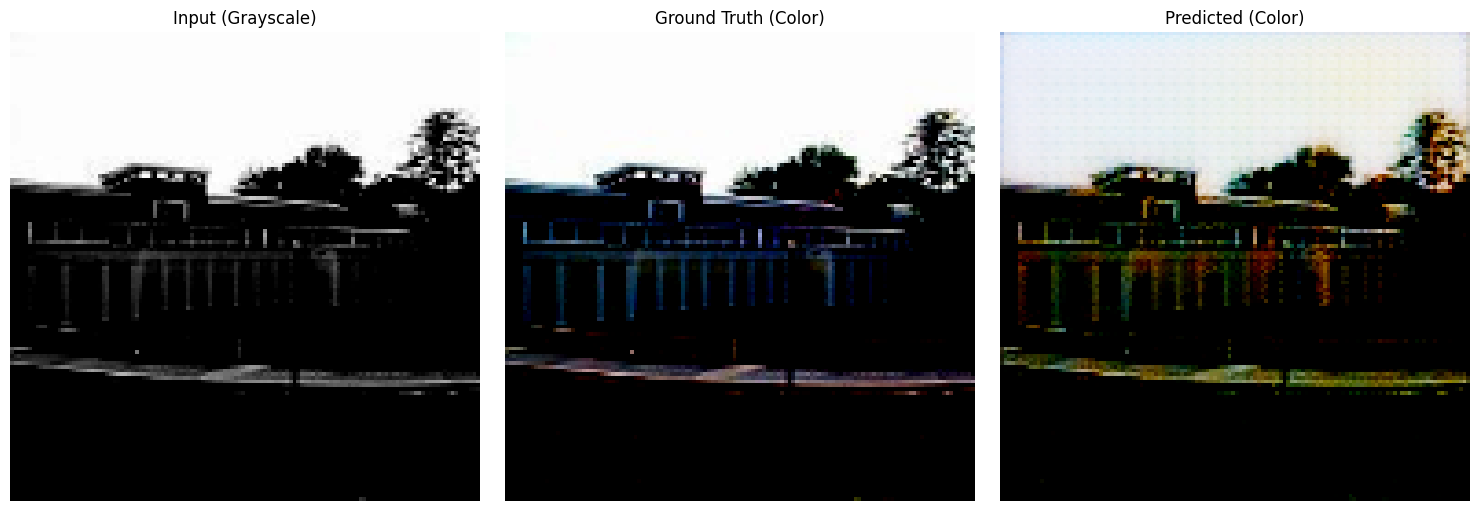

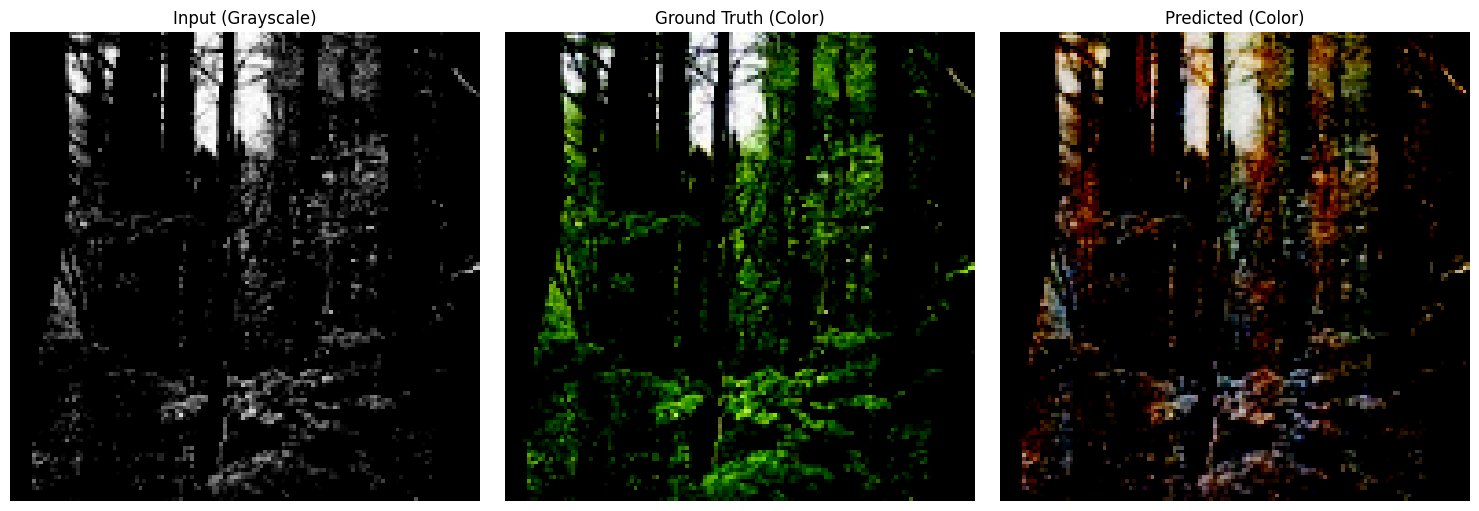

Epoch 21/50
Time taken: 34.66s
Training: Gen Loss: 14.8747, Gen GAN Loss: 6.4423, Gen L1 Loss: 0.0843, Disc Loss: 0.1289
Validation: Gen Loss: 13.9612, Gen GAN Loss: 2.4813, Gen L1 Loss: 0.1148, Disc Loss: 2.1568
Epoch 22/50
Time taken: 35.85s
Training: Gen Loss: 15.3378, Gen GAN Loss: 6.9981, Gen L1 Loss: 0.0834, Disc Loss: 0.0975
Validation: Gen Loss: 13.8361, Gen GAN Loss: 2.6271, Gen L1 Loss: 0.1121, Disc Loss: 2.2664
Epoch 23/50
Time taken: 34.60s
Training: Gen Loss: 13.4680, Gen GAN Loss: 5.3032, Gen L1 Loss: 0.0816, Disc Loss: 0.3035
Validation: Gen Loss: 13.4874, Gen GAN Loss: 2.3065, Gen L1 Loss: 0.1118, Disc Loss: 1.9823
Epoch 24/50


KeyboardInterrupt: 

In [26]:
generator, discriminator = train_model(train_dataset, val_dataset, epochs=50)

In [27]:
import gc

def clear_memory():
    """Clear unused memory aggressively"""
    gc.collect()
    tf.keras.backend.clear_session()
    
    # More aggressive memory clearing in TensorFlow
    for device in tf.config.experimental.list_physical_devices('GPU'):
        try:
            tf.config.experimental.reset_memory_stats(device)
        except:
            pass
            
    # Sleep briefly to allow memory release
    import time
    time.sleep(0.5)
    
clear_memory()
    
